# Feature Pipeline

## Creating Features from Individual Words and N-Grams

July 3, 2019

After playing with some NLP tools and getting a bit of hands on knowledge with the news article data set, it became apparent that certain keywords can provide predictive information for stock prices.

In this notebook, I will build a pipeline to ensure simple and high-quality feature extraction and to have better capabilities for increasing usability in the future.

## Table of Contents

1. ["Library, Module and Data Imports"](#1)
2. ["Feature Creation Pipeline"](#2)
    * ["Text Cleaning"](#2.1)
    * ["Feature Extraction"](#2.2)
    * ["Feature Engineering"](#2.3)
    * ["Feature Reduction"](#2.4)
3. ["Full Pipeline"](#3)

<a id="1"></a>
## Library, Module and Data Imports

In [2]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [3]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

In [4]:
# raw data import
_, watchlist_raw, stock_prices_raw = get_raw_data()
article_raw = clean_and_open_business_wire_data_01(None)

In [5]:
# Base data cleaning and formatting
articles = article_raw.copy()
articles.reset_index(inplace=True)
articles.time = pd.to_datetime(articles.time)

watchlist = watchlist_raw.copy()

<a id="2"></a>
## Feature Creation Pipeline

The pipeline will have 3 major sections:
1. Text Cleaning
2. Feature Extraction
3. Feature Engineering

The diagram below depicts the original concept of how the pipeline would work. As I progressed through the creation of it, slight adjustments were made to ensure everything took a logical approach.

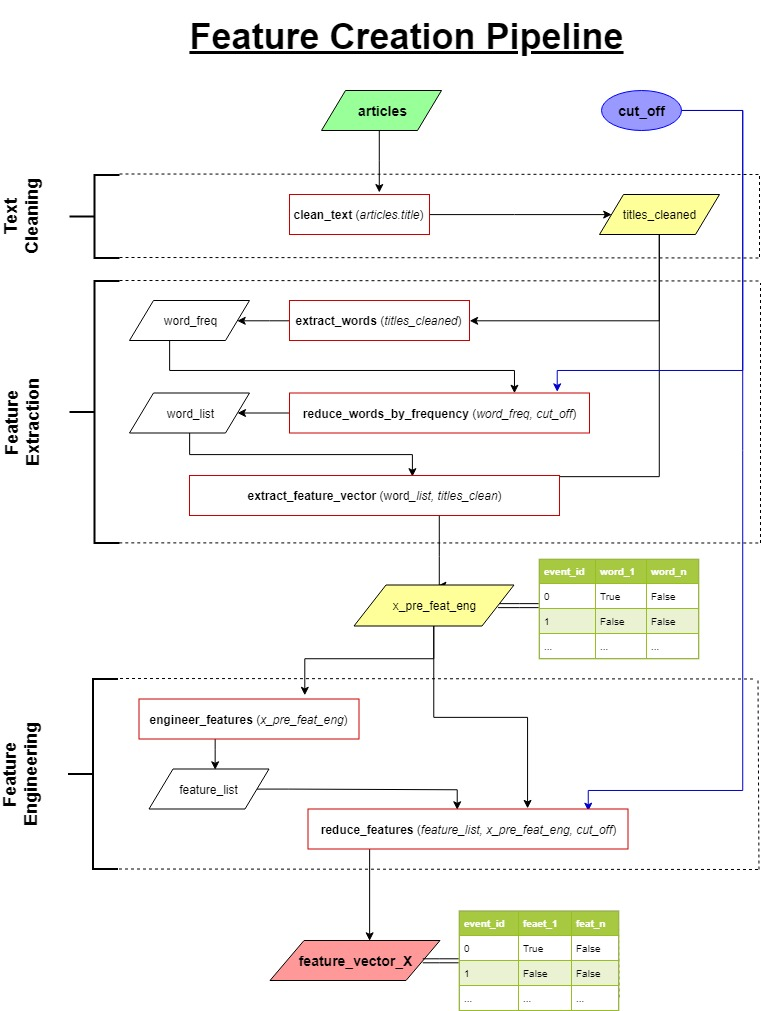

In [6]:
Image("../../reports/figures/NewsArticle_FeatureCreationPipeline_v2.jpg", width=600)

<a id="2.1"></a>
### Text Cleaning

The text cleaning section will follow standard procedures such as removing white spaces, non-alphanumeric values, etc.

Afterwards, since the company name will likely be included in the text, I removed the company's name from each article. The name will be irrelevant for the purpose of this exploration as it can be (if it seems necessary) added in as a feature in a later section.

In [7]:
def preprocess_text_data(articles_full, watchlist, column_name="title"):
    unique_companies = articles_full.ticker.unique()

    # General text cleaning
    cleaned_text = clean_text(articles_full, column_name)[column_name]

    # Remove company name from title
    company_names = watchlist.loc[watchlist.Ticker.isin(unique_companies)].index.tolist()
    return cleaned_text.apply(remove_company_name, args=(company_names,))

In [8]:
titles_cleaned = preprocess_text_data(articles, watchlist, "title")

In [9]:
titles_cleaned.shape

(8433,)

<a id="2.2"></a>
### Feature Extraction

<a id="2.2.1"></a>
#### Extract Words

In the word extraction phase, there will be 3 main things happening:

1. For each unique word, determine the frequency of articles that the word shows up in
2. For each unique word, if the frequency is less than the cut off, remove the word
3. Finally, create the boolean data frame where, if the word is in the article, then the value is true for that word and false otherwise.

In [15]:
def extract_words(text_series):
    full_text_corpus = merge_text(text_series)
    
    unique_words = filter_unique_words(full_text_corpus)
    
    return get_token_frequency_dict(unique_words, text_series)

def merge_text(texts):
    return " ".join(texts.values)

def filter_unique_words(corpus):
    words = set(corpus.split(" "))
    words.remove("")
    return words

def get_token_frequency_dict(token_set, texts):
    return {token: get_token_frequency(token, texts) for token in token_set}

def get_token_frequency(token, texts):
    return sum([1 if token in text else 0 for text in texts.values])/texts.shape[0]

In [16]:
word_freq = extract_words(titles_cleaned)
print(len(word_freq))

7618


<a id="2.2.2"></a>
#### Reduce Number of Words

In [28]:
def reduce_words_by_freq(word_frequency, cut_off=0.01):
    return [word for word in word_frequency.keys() if word_frequency[word] > cut_off]

def remove_short_strings(word_list, min_length=4):
    return [word for word in word_list if len(word) > min_length]

In [29]:
cut_off = 0.005

word_list = remove_short_strings(reduce_words_by_freq(word_freq, cut_off))

In [30]:
len(word_list)

299

So from removing small frequency words and word with a small length we've reduced the word list by a little over 96%!

It would be interesting to go back and see the distribution of these words, so let's take a look at the histogram of frequencies.

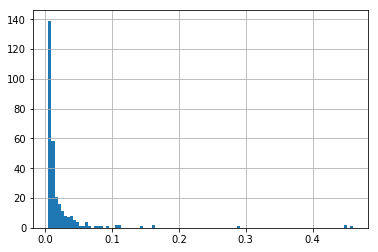

In [34]:
S = pd.Series(word_freq, index=word_freq.keys()).loc[word_list]
S.hist(bins=100)

Alright, so clearly a Pareto distribution here. The drop off is very large and it appears there are not many words breaching 10%.

Let's further explore these words over 10%:

In [37]:
S.loc[S > 0.10]

analysis              0.105419
research              0.450018
search                0.450374
review                0.112416
pipeline              0.162338
report                0.143840
market                0.459979
therapeutic           0.105775
researchandmarkets    0.288628
forecast              0.113127
announce              0.160560
dtype: float64

Interesting! The majority of these words are related to the bio-pharma industry. 

Now, re-plot the histogram to show only the words that have a frequency less than 10%:

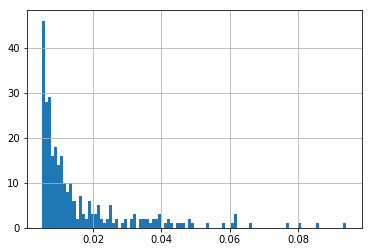

In [38]:
S.loc[S <= 0.10].hist(bins=100)

Now that the graph is zoomed in more, it appears that there aren't a significant number of words even down to about 5%!

What words are they?

In [39]:
S.loc[S > 0.05]

analysis              0.105419
technology            0.061188
research              0.450018
search                0.450374
review                0.112416
invest                0.079806
point                 0.053836
present               0.061544
investor              0.061781
pipeline              0.162338
report                0.143840
market                0.459979
ology                 0.094035
conference            0.060714
result                0.085379
financial             0.057868
quarter               0.076722
therapeutic           0.105775
researchandmarkets    0.288628
finan                 0.066287
forecast              0.113127
announce              0.160560
dtype: float64

So there is a split between financial terms and bio-pharma terms. I would say that this is an expected result with what kind of companies we are dealing with.

I think perhaps in a later notebook, it would be great to further explore this and see if there is some hierarchical structure in the data. It would be good to explore these factors, paired with the factors below the threshold. The reason being that I think these high frequency terms would demarcate the data set into topics well.

<a id="2.2.5"></a>
#### Extract Feature Vectors

In [41]:
def extract_feature_vectors(text_series, features):
    return pd.DataFrame({ind: extract_features_boolean(text, features) for ind, text in text_series.iteritems()}, index=features).T

def extract_features_boolean(text, features):
    return [True if feature in text.split(" ") else False for feature in features]

In [42]:
features = extract_feature_vectors(titles_cleaned, word_list)

In [43]:
features.head()

,analysis,strengthen,molecular,support,neuro,provide,product,launch,science,laboratory,...,collaboration,study,behalf,organ,project,announce,expect,appoint,corporate,price
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Collecting Functions into a Transormation Object

In [44]:
class FeatureExtraction:
    def __init__(self, min_str_length=4):
        self.cut_off = 0
        self.min_str_length = min_str_length
        self.word_list = []
        
    def fit(self, X, cut_off=0.01):
        self.cut_off = cut_off
        word_freq = extract_words(X)
        words_reduced_by_freq = reduce_words_by_freq(word_freq, self.cut_off)
        self.word_list += remove_short_strings(words_reduced_by_freq, self.min_str_length)
    
    def transform(self, X):
        return extract_feature_vectors(X, self.word_list)
    
    def fit_transform(self, X, cut_off=0.01,):
        self.fit(X, cut_off)
        return self.transform(X)

In [55]:
feat_extractor = FeatureExtraction()

x_pre_feat_eng = feat_extractor.fit_transform(titles_cleaned, cut_off=0.005)

x_pre_feat_eng.head()

,analysis,strengthen,molecular,support,neuro,provide,product,launch,science,laboratory,...,collaboration,study,behalf,organ,project,announce,expect,appoint,corporate,price
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


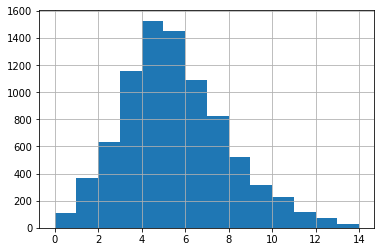

In [56]:
num_feats_per_article = x_pre_feat_eng.sum(axis=1)

_ = num_feats_per_article.hist(bins=num_feats_per_article.max())

<a id="2.3"></a>
### Feature Engineering

<a id="2.2.3"></a>
#### Engineer Features

In [62]:
def engineer_features(words, max_num_grams_per_token=2):
    tokens = []
    
    if max_num_grams_per_token is not None:
        for n in range(2, max_num_grams_per_token+1):
            tokens += get_ngrams(words, n)
        
    return [tok for tok in tokens if type(tok) != str]

def get_ngrams(words, n):
    return combinations(words, n)

In [63]:
max_n = 2 # For this trial, simply will get the individual words

new_feature_list = engineer_features(word_list, max_n)

In [64]:
len(new_feature_list), new_feature_list[0]

(4753, ('industry', 'device'))

In [76]:
def extract_new_feature_vectors(new_feats, x_pre_eng):
    return pd.DataFrame({ind: extract_features_boolean(row, new_feats) for ind, row in x_pre_eng.iterrows()}, index=new_feats).T

def extract_features_boolean(row, features):
    return [extract_tuple_boolean(row, feature) for feature in features]

def extract_tuple_boolean(row, feature):
    return all([row[token] for token in feature])

In [77]:
x_pre_feat_red = extract_new_feature_vectors(new_feature_list, x_pre_feat_eng)

x_pre_feat_red.head()

,"(industry, device)","(industry, result)","(industry, comme)","(industry, financial)","(industry, insight)","(industry, annual)","(industry, treat)","(industry, state)","(industry, patient)","(industry, strategic)",...,"(agnostic, contact)","(agnostic, diagnostics)","(agnostic, development)","(agnostic, appoint)","(contact, diagnostics)","(contact, development)","(contact, appoint)","(diagnostics, development)","(diagnostics, appoint)","(development, appoint)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<a id="2.3.3"></a>
#### Collecting Functions into a Transformation Object

In [102]:
class FeatureEngineering:
    def __init__(self, max_n_grams=2):
        self.max_n_grams = max_n_grams
        self.new_feature_list = []
        
    def fit(self, x):
        self.new_feature_list = engineer_features(x.columns.tolist(), max_n)
    
    def transform(self, x):
        return extract_new_feature_vectors(self.new_feature_list, x)
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

In [103]:
feat_engineer = FeatureEngineering()

x_pre_feat_red = feat_engineer.fit_transform(x_pre_feat_eng)

x_pre_feat_red.head()

,"(industry, device)","(industry, result)","(industry, comme)","(industry, financial)","(industry, insight)","(industry, annual)","(industry, treat)","(industry, state)","(industry, patient)","(industry, advance)",...,"(vendor, diagnostics)","(vendor, drive)","(vendor, development)","(vendor, appoint)","(diagnostics, drive)","(diagnostics, development)","(diagnostics, appoint)","(drive, development)","(drive, appoint)","(development, appoint)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<a id="2.4"></a>
### Feature Reduction

<a id="2.4.1"></a>
#### Reduction by Frequency

In [105]:
def reduce_features_by_frequency(x, cut_off_value):

    features_filtered = x.sum().loc[x.sum() > cut_off_value].index

    return x[features_filtered]

In [96]:
cut_off_value = cut_off * x.shape[0]

x_post_feat_red = reduce_features_by_frequency(x_pre_feat_red, cut_off_value)
x_post_feat_red.shape

(8433, 110)

<a id="2.4.2"></a>
#### Combine Feature Sets

In [95]:
def combine_features(list_of_features):
    return pd.concat(list_of_features, axis=1)

In [97]:
x = combine_features([x_pre_feat_eng, x_post_feat_red])

x.shape

(8433, 262)

<a id="2.4.3"></a>
#### Collecting Functions into a Transformation Object

In [111]:
class FeatureReduction:
    def __init__(self):
        self.cut_off = 0
        self.cut_off_value = 0
        
    def fit(self, num_samples, cut_off=0.01):
        self.cut_off_value = self.cut_off * num_samples
        self.cut_off = cut_off
    
    def transform_individual(self, feature_set):
        return(reduce_features_by_frequency(feature_set, self.cut_off_value))
               
    def transform_batch(self, list_feature_sets):
        return combine_features([self.transform_individual(feature_set) for feature_set in list_feature_sets])
    
    def fit_transform(self, x, cut_off=0.01):
        if type(x) == list:
            num_samples = sum([list_item.shape[1] for list_item in x])
            self.fit(num_samples, cut_off)
            return self.transform_batch(x)
        
        else:
            num_sample = x.shape[1]
            self.fit(x, cut_off)
            return self.transform_individual(x)

In [112]:
feature_reducer = FeatureReduction()

x_post_reduction = feature_reducer.fit_transform([x_pre_feat_eng, x_post_feat_red], 0.01)

<a id="2.3"></a>
### Output

In [114]:
x.shape

(8433, 262)

In [115]:
x_post_reduction.shape

(8433, 262)

<a id="3"></a>
## Full Pipeline

In [2]:
class FeatureCreationPipeline:
    def __init__(self):
        self.cut_off = 0
        self.feat_extractor = FeatureExtraction()
        self.feat_engineer = FeatureEngineering()
        self.feature_reducer = FeatureReduction()
        
        self.x = None
        
    def fit_transform(self, articles, watchlist, cut_off=None):
        if cut_off is not None:
            self.cut_off = cut_off
            
        titles_cleaned = preprocess_text_data(articles, watchlist, "title")
        x_pre_feat_eng = feat_extractor.fit_transform(titles_cleaned, cut_off)
        x_pre_feat_red = feat_engineer.fit_transform(x_pre_feat_eng)
        
        self.x = feature_reducer.fit_transform([x_pre_feat_eng, x_post_feat_red], cut_off)